In [1]:
#
# FULL ENHANCED HTPC + HTM MODEL - Using language
#  Includes L3, plotting, sparse L1 visualization
#
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


# === Minicolumn Encoder ===
class MinicolumnEncoder(nn.Module):
    def __init__(self, n_columns, cells_per_column):
        super().__init__()
        self.n_columns = n_columns
        self.cells_per_column = cells_per_column
        self.total_cells = n_columns * cells_per_column
        self.recurrent_weights = nn.Parameter(torch.zeros(self.total_cells, self.total_cells))

    def activate(self, input_vector, prev_state):
        input_cells = input_vector.repeat_interleave(self.cells_per_column)
        context_input = torch.matmul(self.recurrent_weights, prev_state)
        combined = input_cells + context_input
        combined = combined.view(self.n_columns, self.cells_per_column)
        active_cells = torch.zeros_like(combined)
        #winners = torch.argmax(combined, dim=1)
        noise = 0.01 * torch.rand_like(combined)  # small randomness
        combined += noise
        winners = torch.argmax(combined, dim=1)
        self.last_winners = winners.detach().clone()
        active_cells[range(self.n_columns), winners] = 1.0
        return active_cells.view(-1)

    def learn(self, prev_state, current_state, lr=0.01):
        dw = torch.ger(current_state, prev_state)
        self.recurrent_weights.data += lr * dw

# === HTPC Layer ===
class HTPCLayer(nn.Module):
    def __init__(self, size, next_size=None, prev_size=None):
        super().__init__()
        self.size = size
        self.state = torch.zeros(size)
        self.prediction = torch.zeros(size)
        self.error = torch.zeros(size)
        self.ff_weights = nn.Parameter(torch.randn(size, prev_size) * 0.1) if prev_size else None
        self.fb_weights = nn.Parameter(torch.randn(size, next_size) * 0.1) if next_size else None

    def forward(self, bottom_up=None, top_down=None):
        ff_input = F.linear(bottom_up, self.ff_weights) if self.ff_weights is not None and bottom_up is not None else 0
        fb_input = F.linear(top_down, self.fb_weights) if self.fb_weights is not None and top_down is not None else 0
        #self.state = torch.tanh(ff_input + fb_input)
        self.state = torch.relu(ff_input + fb_input)  # OR
        #self.state = ff_input + fb_input  # Raw linear
        self.prediction = fb_input
        self.error = self.state - self.prediction
        return self.state, self.error

# === Full HTPC-HTM Model with L3 and visualization ===
class HTPCModelHTM(nn.Module):
    def __init__(self, n_columns=10, cells_per_column=16, l2_size=10, l3_size=5):
        super().__init__()
        self.encoder = MinicolumnEncoder(n_columns, cells_per_column)
        self.n_input = n_columns * cells_per_column
        self.L2 = HTPCLayer(l2_size, prev_size=self.n_input, next_size=l3_size)
        self.L3 = HTPCLayer(l3_size, prev_size=l2_size)
        self.L1_fb = nn.Parameter(torch.randn(self.n_input, l2_size) * 0.1)

        self.prev_L1_state = torch.zeros(self.n_input)
        self.current_input_column = torch.zeros(n_columns)

        # Logs
        self.log_L1_acts = []
        self.log_L1_error = []
        self.log_L2_error = []

    def forward(self, column_input):
        self.current_input_column = column_input.clone()

        # L1 Activation
        L1_state = self.encoder.activate(column_input, self.prev_L1_state)

        # Feedforward
        L2_state, _ = self.L2.forward(bottom_up=L1_state)
        L3_state, _ = self.L3.forward(bottom_up=self.L2.state)

        # Feedback
        self.L2.forward(top_down=L3_state)
        #L1_pred = F.linear(self.L2.state, self.L1_fb)
        self.L1_pred_bias = nn.Parameter(torch.zeros(self.n_input))
        L1_pred = F.linear(self.L2.state, self.L1_fb) + self.L1_pred_bias
        L1_error = L1_state - L1_pred

        # Logs
        self.log_L1_acts.append(L1_state.detach().numpy())
        self.log_L1_error.append(torch.sum(L1_error ** 2).item())
        self.log_L2_error.append(torch.sum(self.L2.error ** 2).item())

        self.prev_L1_state = L1_state.clone()
        #print("FF dW (L2):", torch.norm(torch.ger(self.L2.error, self.prev_L1_state)).item())
        #print("FB dW (L1):", torch.norm(torch.ger(-self.prev_L1_state, self.L2.state)).item())
        return {"L1_error": L1_error}

    def learn(self, lr=0.01):
        with torch.no_grad():
            pred = F.linear(self.L2.state, self.L1_fb)
            error = self.prev_L1_state - pred
            self.L1_fb += lr * torch.ger(error, self.L2.state)

            self.L2.ff_weights += lr * torch.ger(self.L2.error, self.prev_L1_state)
            self.L3.ff_weights += lr * torch.ger(self.L3.error, self.L2.state)

            new_L1_state = self.encoder.activate(self.current_input_column, self.prev_L1_state)
            self.encoder.learn(self.prev_L1_state, new_L1_state, lr=lr)


    def reset_logs(self):
        self.log_L1_acts.clear()
        self.log_L1_error.clear()
        self.log_L2_error.clear()

    def plot_results(self):
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        axs[0].imshow(np.array(self.log_L1_acts).T, aspect='auto', cmap='Greys')
        axs[0].set_title("L1 Sparse Activations (minicolumn cells)")
        axs[0].set_ylabel("Cell index")

        axs[1].plot(self.log_L1_error, label='L1 Error', color='magenta')
        axs[1].set_title("L1 Prediction Error")
        axs[1].set_ylabel("MSE")

        axs[2].plot(self.log_L2_error, label='L2 Error', color='orange')
        axs[2].set_title("L2 Prediction Error")
        axs[2].set_ylabel("MSE")
        axs[2].set_xlabel("Time step")

        plt.tight_layout()
        plt.show()


In [2]:
sequences = [
    ["the", "cat", "sat"],
    ["the", "dog", "ran"],
    ["the", "cat", "ran"],
    ["the", "dog", "sat"]
]

# Build a word-to-column mapping
words = sorted(set(word for seq in sequences for word in seq))
word_to_column = {word: i for i, word in enumerate(words)}  # e.g., {"the": 0, "cat": 1, ...}

def encode_word(word, n_columns):
    vec = torch.zeros(n_columns)
    if word in word_to_column:
        vec[word_to_column[word]] = 1.0
    return vec

# Setup
n_columns = len(word_to_column)
cells_per_column = 16
model = HTPCModelHTM(n_columns=n_columns, cells_per_column=cells_per_column, l2_size=10, l3_size=5)


# Build overlapping sequences
def make_column_input(indices):
    vec = torch.zeros(n_columns)
    vec[indices] = 1.0
    return vec

# === TRAINING ===
model.reset_logs()

for epoch in range(30):
    for seq in sequences:
        model.prev_L1_state = torch.zeros_like(model.prev_L1_state)

        for i in range(len(seq)):
            word = seq[i]
            column_input = encode_word(word, n_columns)

            model.forward(column_input)

            if i > 0:
                model.learn(lr=0.01)

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def build_l1_cell_graph(encoder, word_to_column):
    G = nx.DiGraph()

    n_columns = encoder.n_columns
    cpc = encoder.cells_per_column
    W = encoder.recurrent_weights.detach().numpy()

    for pre in range(W.shape[1]):
        for post in range(W.shape[0]):
            weight = W[post, pre]
            if weight > 0.01:  # threshold small weights
                pre_col = pre // cpc
                pre_cell = pre % cpc
                post_col = post // cpc
                post_cell = post % cpc

                pre_word = [w for w, idx in word_to_column.items() if idx == pre_col]
                post_word = [w for w, idx in word_to_column.items() if idx == post_col]

                pre_label = f"{pre_word[0]}_c{pre_cell}" if pre_word else f"col{pre_col}_c{pre_cell}"
                post_label = f"{post_word[0]}_c{post_cell}" if post_word else f"col{post_col}_c{post_cell}"

                G.add_edge(pre_label, post_label, weight=weight)

    return G


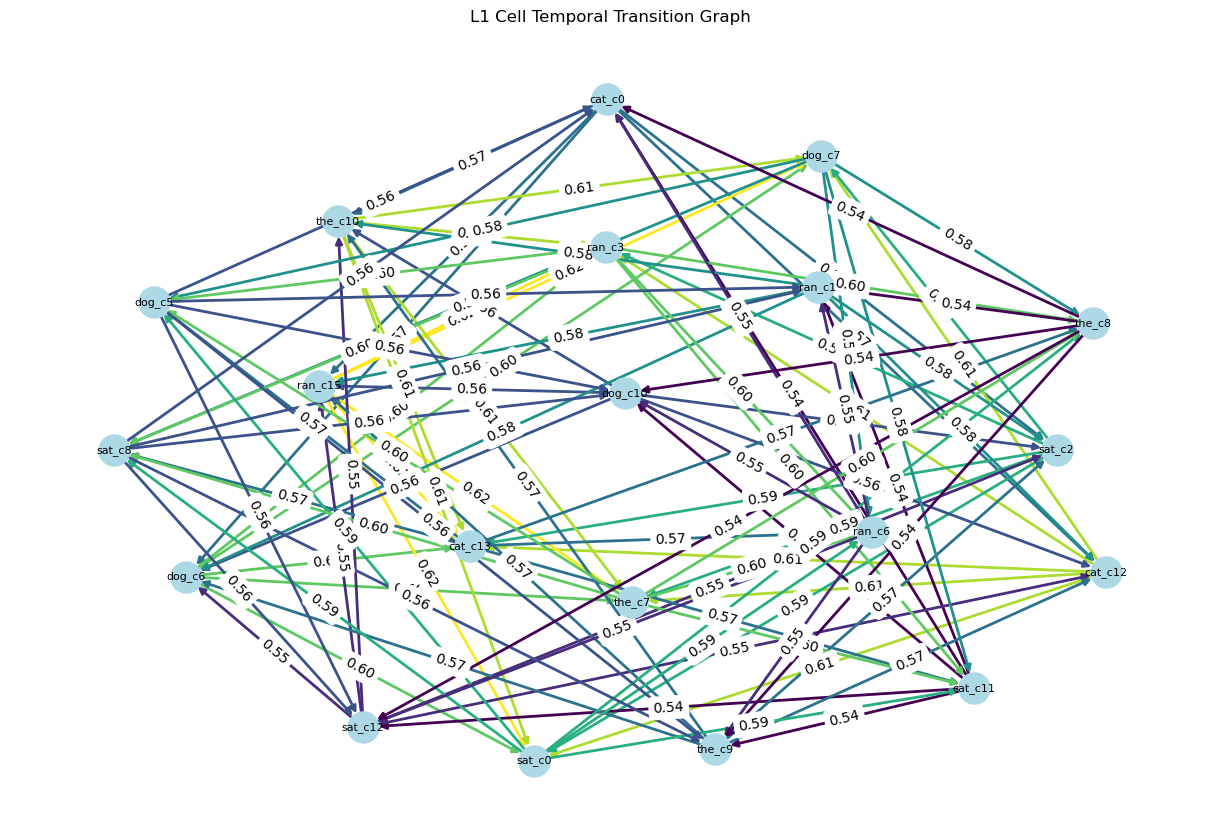

In [4]:
G = build_l1_cell_graph(model.encoder, word_to_column)

# Draw weighted graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=8,
        edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})
plt.title("L1 Cell Temporal Transition Graph")
plt.show()
